# A very basic implementation of single Q learning

Single Q-learning tends to overestimate the action values because it uses the same Q-values both to select and to evaluate an action. This overestimation can lead to suboptimal policies, particularly in complex environments with many state-action pairs.###

Here we have given much more control to the agent such that collisions can also happen by severe decisions

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import gym
from gym import spaces

Final Q-table:
[[[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]]

   [[ 8.99900000e+03  7.94183037e+03  8.01153219e+03  7.20648711e+03
      8.03855925e+03  7.95122929e+03]
    [ 4.67476591e+03  7.15575960e+03  7.27520298e+03  8.04870728e+03
      7.22563848e+03  7.08567556e+03]
    [ 8.61520923e+03  7.08720238e+03  7.31546690e+03  6.30184338e+03
      7.63095638e+03  7.47283036e+03]
    [ 7.56251434e+03

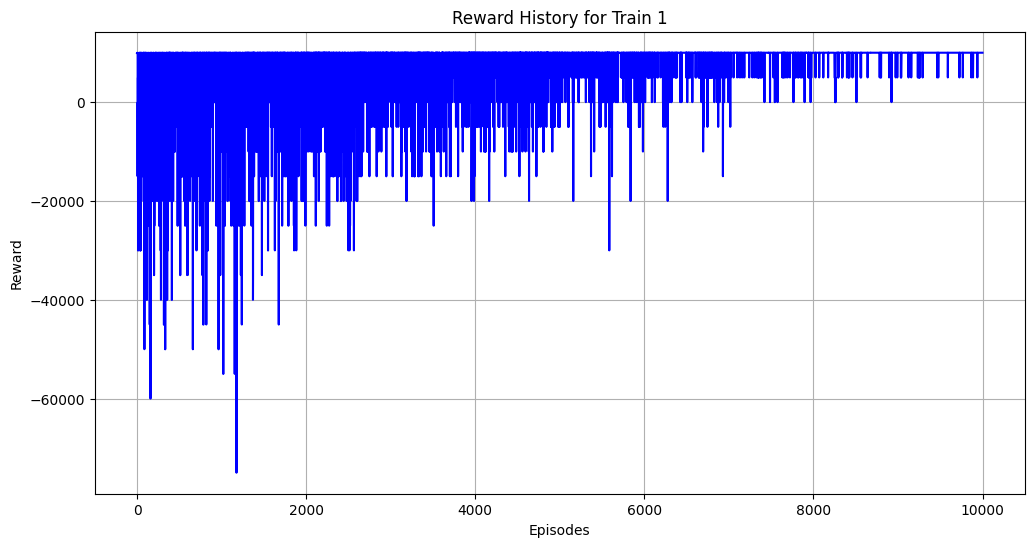

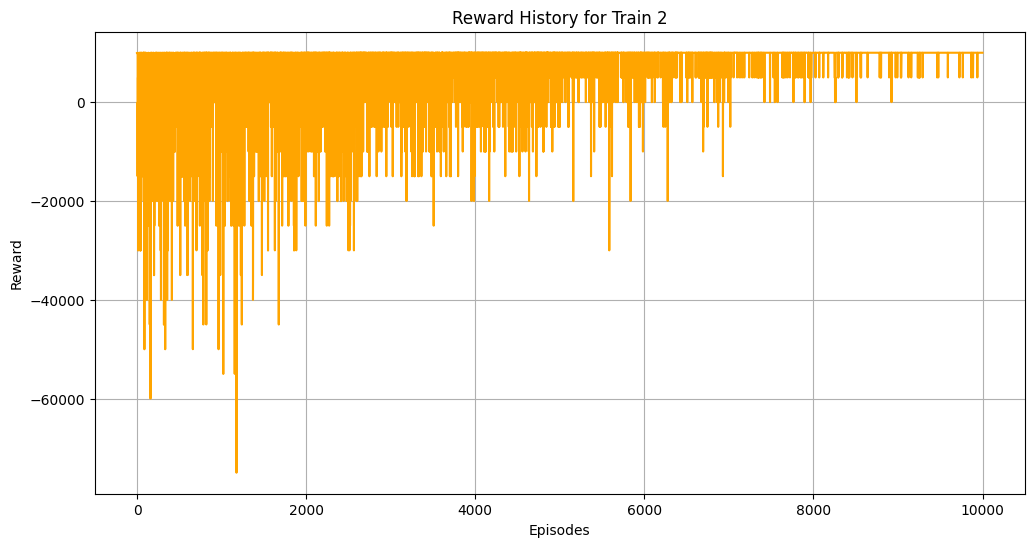

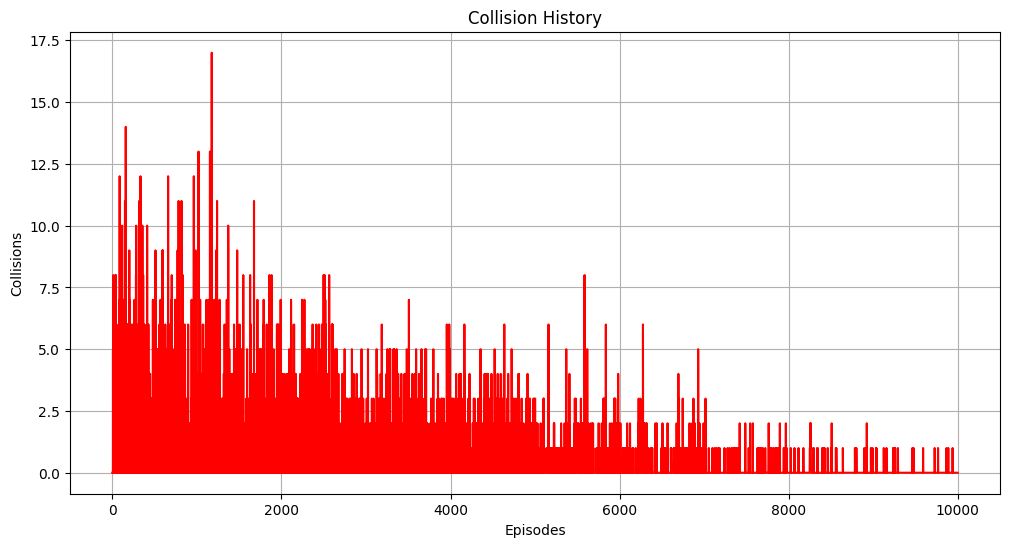

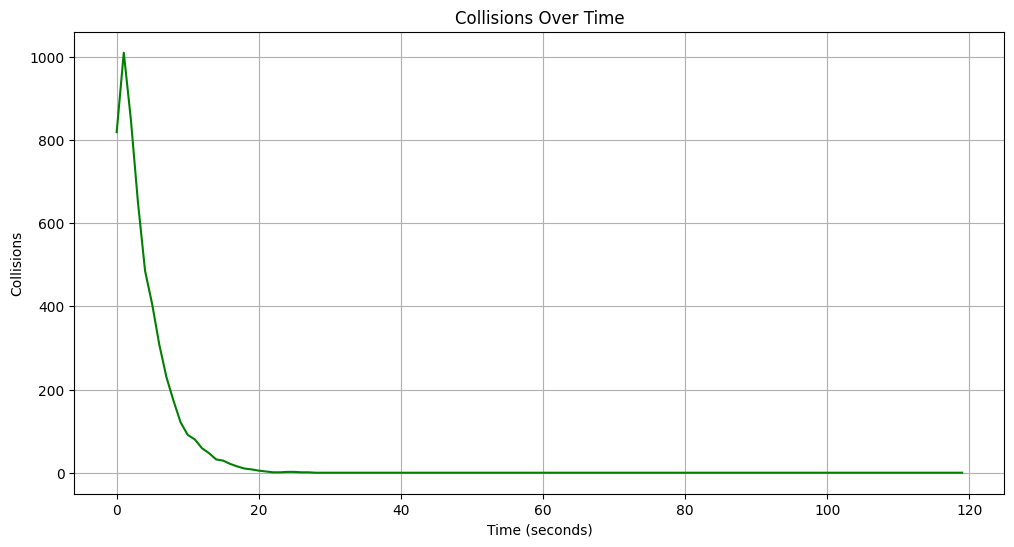

Total collisions over 10000 episodes: 5457
Collisions in the first half of episodes: 4789
Collisions in the second half of episodes: 668
Average collisions per episode in the first half: 0.9578
Average collisions per episode in the second half: 0.1336


In [2]:
# Define the TrainEnvironment class
class TrainEnvironment(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(TrainEnvironment, self).__init__()
        self.locations = ['Platform A', 'Platform B', 'On route to B', 'Station B']
        self.speeds = [50, 100, 150, 200, 250, 300]  # Speeds in km/h
        self.num_locations = len(self.locations)
        self.num_speeds = len(self.speeds)
        self.actions = ['Depart', 'Arrive', 'Wait', 'Speed Up', 'Slow Down', 'Maintain Speed']
        self.num_actions = len(self.actions)
        
        # Define action and observation space
        self.action_space = spaces.MultiDiscrete([self.num_actions, self.num_actions])
        self.observation_space = spaces.MultiDiscrete([self.num_locations, self.num_speeds, self.num_locations, self.num_speeds])
        
        self.state = None

    def reset(self):
        self.state = ('Platform A', 50, 'Platform B', 50)  # Starting state
        return self._get_state_index(self.state)
    
    def step(self, actions):
        loc1, spd1, loc2, spd2 = self.state
        action1, action2 = self.actions[actions[0]], self.actions[actions[1]]
        
        next_loc1, next_spd1 = self._transition(loc1, spd1, action1)
        next_loc2, next_spd2 = self._transition(loc2, spd2, action2)
        
        collision = self._check_collision(next_loc1, next_loc2)
        reward1 = self._reward_function(loc1, action1, collision)
        reward2 = self._reward_function(loc2, action2, collision)
        
        if collision:
            reward1 = reward2 = -5000
        
        self.state = (next_loc1, next_spd1, next_loc2, next_spd2)
        done = self._is_terminal(next_loc1) and self._is_terminal(next_loc2)
        return self._get_state_index(self.state), (reward1, reward2), done, {}
    
    def render(self, mode='human'):
        print(f"Train 1: Location={self.state[0]}, Speed={self.state[1]}")
        print(f"Train 2: Location={self.state[2]}, Speed={self.state[3]}")
    
    def _get_state_index(self, state):
        loc1_idx = self.locations.index(state[0])
        spd1_idx = self.speeds.index(state[1])
        loc2_idx = self.locations.index(state[2])
        spd2_idx = self.speeds.index(state[3])
        return (loc1_idx, spd1_idx, loc2_idx, spd2_idx)
    
    def _reward_function(self, location, action, collision):
        if collision:
            return -5000
        if location == 'On route to B' and action == 'Arrive':
            return 10000
        elif action == 'Depart':
            return -1
        elif action == 'Wait':
            return -5
        elif action == 'Speed Up':
            return -2
        elif action == 'Slow Down':
            return -2
        elif action == 'Maintain Speed':
            return 0
        else:
            return -10
    
    def _transition(self, location, speed, action):
        if action == 'Speed Up' and speed < 300:
            speed += 50
        elif action == 'Slow Down' and speed > 50:
            speed -= 50
        
        transitions = {
            ('Platform A', 'Depart'): 'On route to B',
            ('Platform B', 'Depart'): 'On route to B',
            ('On route to B', 'Arrive'): 'Station B',
        }
        next_location = transitions.get((location, action), location)
        return next_location, speed
    
    def _is_terminal(self, location):
        return location == 'Station B'
    
    def _check_collision(self, location1, location2):
        return location1 == location2 and location1 == 'On route to B'

# Replay buffer for experience replay
class ReplayBuffer:
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size=64):
        sampled_indices = np.random.choice(len(self.buffer), size=batch_size)
        return [self.buffer[idx] for idx in sampled_indices]

    def size(self):
        return len(self.buffer)

# Q-learning parameters
num_episodes = 10000
alpha = 0.1
gamma = 0.9
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = (epsilon_start - epsilon_end) / num_episodes
buffer = ReplayBuffer()

# Store reward and collision history for visualization
reward_history1 = []
reward_history2 = []
collision_history = []
collision_over_time = np.zeros(120)  # Track collisions for 120 seconds
Q_history = []

# Initialize Q-table
locations = ['Platform A', 'Platform B', 'On route to B', 'Station B']
speeds = [50, 100, 150, 200, 250, 300]
actions = ['Depart', 'Arrive', 'Wait', 'Speed Up', 'Slow Down', 'Maintain Speed']
num_actions = len(actions)

Q = np.zeros((len(locations), len(speeds), len(locations), len(speeds), num_actions))

# Create Gym environment
env = TrainEnvironment()

# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    episode_reward1 = 0
    episode_reward2 = 0
    collisions = 0
    epsilon = max(epsilon_end, epsilon_start - episode * epsilon_decay)
    
    time_remaining = 120  # Each train has 120 seconds to complete the journey
    time_step = 0

    while time_remaining > 0:
        loc1_idx, spd1_idx, loc2_idx, spd2_idx = state
        
        if random.uniform(0, 1) < epsilon:
            action1_idx = random.choice(range(num_actions))
            action2_idx = random.choice(range(num_actions))
        else:
            action1_idx = np.argmax(Q[loc1_idx, spd1_idx, loc2_idx, spd2_idx, :])
            action2_idx = np.argmax(Q[loc2_idx, spd2_idx, loc1_idx, spd1_idx, :])
        
        actions = (action1_idx, action2_idx)
        next_state, rewards, done, _ = env.step(actions)
        reward1, reward2 = rewards
        
        next_loc1_idx, next_spd1_idx, next_loc2_idx, next_spd2_idx = next_state
        
        collision = env._check_collision(env.locations[next_loc1_idx], env.locations[next_loc2_idx])
        if collision:
            collisions += 1
            collision_over_time[time_step] += 1
        
        # Add experiences to replay buffer
        buffer.add((loc1_idx, spd1_idx, loc2_idx, spd2_idx, action1_idx, reward1, next_loc1_idx, next_spd1_idx))
        buffer.add((loc2_idx, spd2_idx, loc1_idx, spd1_idx, action2_idx, reward2, next_loc2_idx, next_spd2_idx))
        
        episode_reward1 += reward1
        episode_reward2 += reward2
        
        state = next_state
        
        time_remaining -= 1  # Decrement time remaining
        time_step += 1

        if done:
            break
    
    # Replay and update Q-values
    if buffer.size() >= 64:
        batch = buffer.sample()
        for experience in batch:
            state_idx, speed_idx, other_state_idx, other_speed_idx, action_idx, reward, next_state_idx, next_speed_idx = experience
            # Single Q-learning update
            Q[state_idx, speed_idx, other_state_idx, other_speed_idx, action_idx] += alpha * (
                reward + gamma * np.max(Q[next_state_idx, next_speed_idx, other_state_idx, other_speed_idx, :]) - Q[state_idx, speed_idx, other_state_idx, other_speed_idx, action_idx]
            )
    
    reward_history1.append(episode_reward1)
    reward_history2.append(episode_reward2)
    collision_history.append(collisions)
    Q_history.append(Q.copy())

# Print the learned Q-table
print("Final Q-table:")
print(Q)

# Plot reward history for both trains separately
plt.figure(figsize=(12, 6))
plt.plot(reward_history1, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward History for Train 1')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(reward_history2, color='orange')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward History for Train 2')
plt.grid(True)
plt.show()

# Plot collision history
plt.figure(figsize=(12, 6))
plt.plot(collision_history, color='red')
plt.xlabel('Episodes')
plt.ylabel('Collisions')
plt.title('Collision History')
plt.grid(True)
plt.show()

# Plot collisions over time
plt.figure(figsize=(12, 6))
plt.plot(range(120), collision_over_time, color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Collisions')
plt.title('Collisions Over Time')
plt.grid(True)
plt.show()

# Calculate and print collision statistics
total_collisions = sum(collision_history)
print(f"Total collisions over {num_episodes} episodes: {total_collisions}")

collisions_first_half = sum(collision_history[:num_episodes//2])
collisions_second_half = sum(collision_history[num_episodes//2:])
print(f"Collisions in the first half of episodes: {collisions_first_half}")
print(f"Collisions in the second half of episodes: {collisions_second_half}")

average_collisions_first_half = collisions_first_half / (num_episodes//2)
average_collisions_second_half = collisions_second_half / (num_episodes//2)
print(f"Average collisions per episode in the first half: {average_collisions_first_half}")
print(f"Average collisions per episode in the second half: {average_collisions_second_half}")

Learned Q-table after testing:
[[[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]]

   [[ 8.99900000e+03  7.94183037e+03  8.01153219e+03  7.20648711e+03
      8.03855925e+03  7.95122929e+03]
    [ 4.67476591e+03  7.15575960e+03  7.27520298e+03  8.04870728e+03
      7.22563848e+03  7.08567556e+03]
    [ 8.61520923e+03  7.08720238e+03  7.31546690e+03  6.30184338e+03
      7.63095638e+03  7.47283036e+03]
    

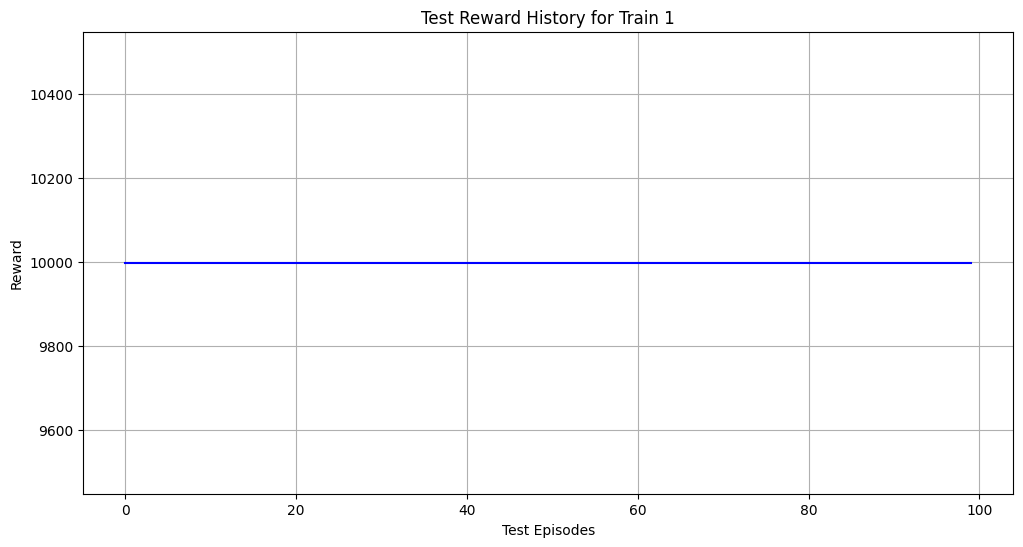

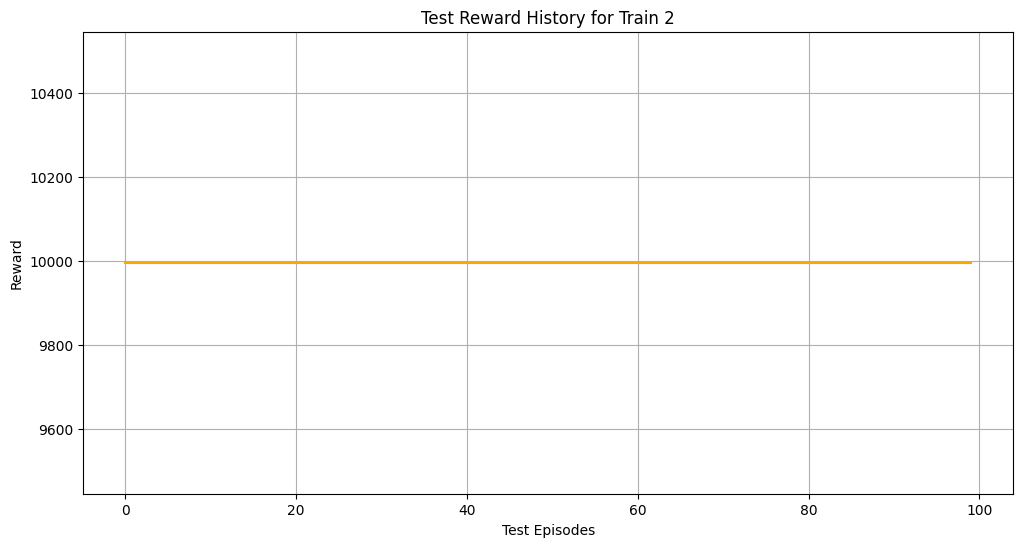

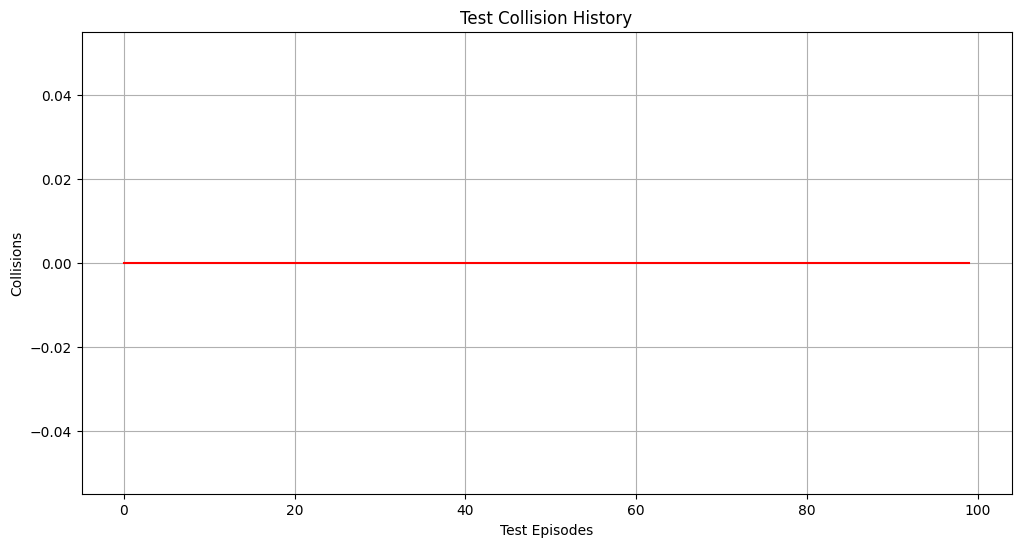

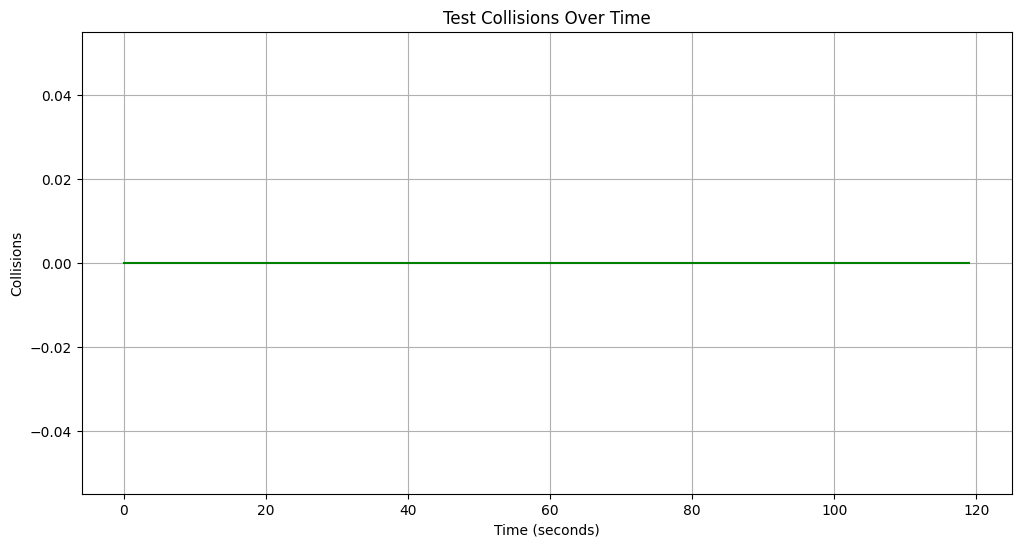

Total collisions over 100 test episodes: 0
Collisions in the first half of test episodes: 0
Collisions in the second half of test episodes: 0
Average collisions per test episode in the first half: 0.0
Average collisions per test episode in the second half: 0.0


In [3]:
 # Parameters for testing
num_test_episodes = 100  # Number of episodes to test the trained agent
test_epsilon = 0.0       # Set epsilon to 0 to use only the learned Q-values

# Store reward and collision history for testing
test_reward_history1 = []
test_reward_history2 = []
test_collision_history = []
test_collision_over_time = np.zeros(120)  # Track collisions for 120 seconds during testing

# Run test episodes
for episode in range(num_test_episodes):
    state = env.reset()
    episode_reward1 = 0
    episode_reward2 = 0
    collisions = 0
    time_remaining = 120  # Each train has 120 seconds to complete the journey
    time_step = 0

    while time_remaining > 0:
        loc1_idx, spd1_idx, loc2_idx, spd2_idx = state
        
        action1_idx = np.argmax(Q[loc1_idx, spd1_idx, loc2_idx, spd2_idx, :])
        action2_idx = np.argmax(Q[loc2_idx, spd2_idx, loc1_idx, spd1_idx, :])
        
        actions = (action1_idx, action2_idx)
        next_state, rewards, done, _ = env.step(actions)
        reward1, reward2 = rewards
        
        next_loc1_idx, next_spd1_idx, next_loc2_idx, next_spd2_idx = next_state
        
        collision = env._check_collision(env.locations[next_loc1_idx], env.locations[next_loc2_idx])
        if collision:
            collisions += 1
            test_collision_over_time[time_step] += 1
        
        episode_reward1 += reward1
        episode_reward2 += reward2
        
        state = next_state
        
        time_remaining -= 1  # Decrement time remaining
        time_step += 1

        if done:
            break
    
    test_reward_history1.append(episode_reward1)
    test_reward_history2.append(episode_reward2)
    test_collision_history.append(collisions)

# Print the learned Q-table after testing
print("Learned Q-table after testing:")
print(Q)

# Plot reward history for both trains separately during testing
plt.figure(figsize=(12, 6))
plt.plot(test_reward_history1, color='blue')
plt.xlabel('Test Episodes')
plt.ylabel('Reward')
plt.title('Test Reward History for Train 1')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_reward_history2, color='orange')
plt.xlabel('Test Episodes')
plt.ylabel('Reward')
plt.title('Test Reward History for Train 2')
plt.grid(True)
plt.show()

# Plot collision history during testing
plt.figure(figsize=(12, 6))
plt.plot(test_collision_history, color='red')
plt.xlabel('Test Episodes')
plt.ylabel('Collisions')
plt.title('Test Collision History')
plt.grid(True)
plt.show()

# Plot collisions over time during testing
plt.figure(figsize=(12, 6))
plt.plot(range(120), test_collision_over_time, color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Collisions')
plt.title('Test Collisions Over Time')
plt.grid(True)
plt.show()

# Calculate and print collision statistics for testing
total_test_collisions = sum(test_collision_history)
print(f"Total collisions over {num_test_episodes} test episodes: {total_test_collisions}")

collisions_first_half_test = sum(test_collision_history[:num_test_episodes//2])
collisions_second_half_test = sum(test_collision_history[num_test_episodes//2:])
print(f"Collisions in the first half of test episodes: {collisions_first_half_test}")
print(f"Collisions in the second half of test episodes: {collisions_second_half_test}")

average_collisions_first_half_test = collisions_first_half_test / (num_test_episodes//2)
average_collisions_second_half_test = collisions_second_half_test / (num_test_episodes//2)
print(f"Average collisions per test episode in the first half: {average_collisions_first_half_test}")
print(f"Average collisions per test episode in the second half: {average_collisions_second_half_test}")